In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import log,exp
import sys

#local imports 
import lazy
from lazy import Data
import misc


Data includes
sig_probs , complete_insertions , sigs_pres , samples , complete_deletions , sub_chromo , ins_extra , del_extra , converter , longest , muts , corr_del , corr_ins , mutation_breakdown , sixes_distribution , triplets_distribution , missense_lnd , silent_lnd , nonsense_lnd , del_frameshift_lnd , del_inframe_lnd , ins_frameshift_lnd , ins_inframe_lnd , lnds , sub_lnds , log_ins_lengths , log_del_lengths , nw_perc_del , nw_perc_ins , nw_perc_del , nw_perc_ins , quads , fingerprints , A_C_lnd , A_G_lnd , A_T_lnd , C_A_lnd , C_G_lnd , C_T_lnd , G_A_lnd , G_C_lnd , G_T_lnd , T_A_lnd , T_C_lnd , T_G_lnd , 

Purpose of notebook is to extract indels from cosmic non-coding mutation database.

First run N0_Setup and then 

download CosmicNCV.tsv. 

Point the path 'path_to_cosmicncv' to the position of the download.

This notebook identifies repeats in the non-coding indels,
but it also looks for depletions and enrichments etc.

In [ ]:
print('download CosmicNCV.tsv')
path_to_cosmicncv=input('path to CosmicNCV.tsv ')

In [ ]:
def get_nc(m,n,path_to_cosmicncv):
    '''read specific lines from the Cosmic non coding mutation database'''
    with open(path_to_cosmicncv,'r') as f:
        columns = f.readline().split('\t')
        if m>0:
            for i in range(m):
                f.readline()
        g0 = []
        for i in range(n-m):
            row = f.readline().split('\t')
            if len(row)==27:
                g0.append(row)
            else:
                break
        g = pd.DataFrame(g0,columns = columns)[
            ['genome position','WT_SEQ','MUT_SEQ']]
    return g

In [ ]:


def get_nc_indels(path_to_cosmicncv):
    '''extract just the indels from the Cosmic non coding mutation database '''
    
    indels = []
    for n in range(23):
        g = get_nc(1000000*n,1000000*(n+1),path_to_cosmicncv)
        w = g['WT_SEQ'].map(lambda x:len(x))
        m = g['MUT_SEQ'].map(lambda x:len(x))
        indels.append(g.loc[(w-m)!=0])
        print(n,' ', end = '')


    just_indels = pd.concat(indels)
    just_indels.to_csv('non_coding_indels.csv')

In [3]:
#Make a dictionary of all the indels based on chromosome
#load the just_indels, split the genome position up into chromo, start,stop then put into a dictionary

def make_just():
    '''just_indels_dict is a dictionary of indels in chromosome
    i'''
    just_indels = Data.non_coding_indels()
    just_indels = just_indels.fillna('')
    len_dels = just_indels['WT_SEQ'].map(lambda x: len(x))
    chromo = just_indels['genome position'].map(lambda x:x.split(':')[0])
    temp = just_indels['genome position'].map(lambda x:x.split(':')[1])
    start = temp.map(lambda x:x.split('-')[0]).astype(int)
    stop = temp.map(lambda x:x.split('-')[1]).astype(int)
    extra = pd.DataFrame({'chromo':chromo,'start':start,'stop':stop})

    just_indels = pd.concat([just_indels,extra],axis=1)
    just_indels.index = range(just_indels.shape[0])
    just_indels.fillna('',inplace = True)

    groups = just_indels.groupby(by = 'chromo').groups

    just_indel_dict = dict([i,just_indels.loc[groups[str(i)]]] 
                           for i in range(1,24))

    deletions = set(just_indels.loc[just_indels['MUT_SEQ'].map(lambda x:len(x)==0)].index)
    insertions = set(just_indels.loc[just_indels['WT_SEQ'].map(lambda x:len(x)==0)].index)
    just_dels = just_indels.reindex(deletions)
    just_ins = just_indels.reindex(insertions)
    
    return just_dels,just_ins,just_indels,just_indel_dict,deletions,insertions

just_dels,just_ins,just_indels,just_indel_dict,deletions,insertions = make_just()

def get_indel_type(n,indel_type):
    df = just_indel_dict[n]
    indices = {'insertions':insertions,'deletions':deletions}[indel_type]
    return df.reindex(set(df.index)&indices)




## What follows is an exploration of the types of dinucleotides we get

In [13]:

di = [i+j for i in 'ACGT' for j in 'ACGT']

del_nums =lambda num: just_dels.loc[just_dels['WT_SEQ'].map(
    lambda x:len(x)==num)]
tempd = del_nums(2)['WT_SEQ'].value_counts()
tempd = tempd.reindex(di)/tempd.sum()

ins_nums = lambda num:just_ins.loc[just_ins['MUT_SEQ'].map(
    lambda x:len(x)==num)]

tempi = ins_nums(2)['MUT_SEQ'].value_counts()
tempi = tempi.reindex(di)/tempi.sum()

tempdf = pd.DataFrame([tempi,tempd]).T

tempdf.plot.bar()
plt.show()


def show_CG(num,indel_type):
    
    column  ={'del':'WT_SEQ','ins':'MUT_SEQ'}[indel_type]
    vc = eval('{}_nums'.format(indel_type))(num)[column].value_counts().index
    print(vc)
    the_map = lambda x: 'CG' in x
    
    _=plt.plot(np.cumsum(vc.map(the_map).astype(int).values))

def n_nucs(n):
    nucs = ['A','C','G','T']
    new_list = nucs.copy()

    for i in range(n-1):
        new_list =[a+b for a in new_list for b in nucs]
    return new_list

for i in range(4,10,2):
    plt.show()
    for j in ['ins','del']:
        print(i,j)
        show_CG(i,j)

nucs4 = n_nucs(4)

print(sum([1 for i in nucs4 if 'CG' in i]), len(nucs4))


nucs6 = n_nucs(6)

print(sum([1 for i in nucs6 if 'CG' in i]), len(nucs6))

nucs8 = n_nucs(8)

print(sum([1 for i in nucs8 if 'CG' in i]), len(nucs8))

def get_enrichment(num, indel_type):
    '''show how the repeated dinucleotides cluster 
    in the indels of length num'''
    
    column  ={'del':'WT_SEQ','ins':'MUT_SEQ'}[indel_type]
    vc = eval('{}_nums'.format(indel_type))(num)[column].value_counts().index
    print(vc)
    
    def the_map(x):
        for i in range(0,num-2,2):
            if x[i:i+2]!=x[i+2:i+4]:
                return False
        return True
    
    plt.plot(np.cumsum(vc.map(the_map).astype(int).values))
    

for i in range(4,10,2):
    plt.show()
    for j in ['ins','del']:
        print(i,j)
        get_enrichment(i,j)
        

## The end of exploration of dinucleotides

## positioning of centromeres


In [176]:
j = [i.split('\t')[:4] for i in '''1	125.0 	metacentric 	247.2 	7.4
2 	93.3 	submetacentric 	242.8 	6.3
3 	91.0 	metacentric 	199.4 	6.0
4 	50.4 	submetacentric 	191.3 	—
5 	48.4 	submetacentric 	180.8 	—
6 	61.0 	submetacentric 	170.9 	—
7 	59.9 	submetacentric 	158.8 	—
8 	45.6 	submetacentric 	146.3 	—
9 	49.0 	submetacentric 	140.4 	—
10 	40.2 	submetacentric 	135.4 	—
11 	53.7 	submetacentric 	134.5 	—
12 	35.8 	submetacentric 	132.3 	—
13 	17.9 	acrocentric 	114.1 	—
14 	17.6 	acrocentric 	106.3 	—
15 	19.0 	acrocentric 	100.3 	—
16 	36.6 	metacentric 	88.8 	—
17 	24.0 	submetacentric 	78.7 	—
18 	17.2 	submetacentric 	76.1 	—
19 	26.5 	metacentric 	63.8 	—
20 	27.5 	metacentric 	62.4 	—
21 	13.2 	acrocentric 	46.9 	—
22 	14.7 	acrocentric 	49.5 	— '''.split('\n')]

In [181]:
centromere = (pd.Series([float(i[1])/float(i[3]) for i in j])*100).astype(int)

In [ ]:
just_indel_dict[1]['start']

248945624
1
49
50


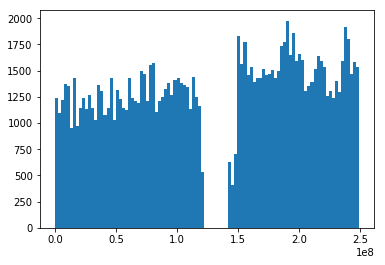

243179409
2
38
38


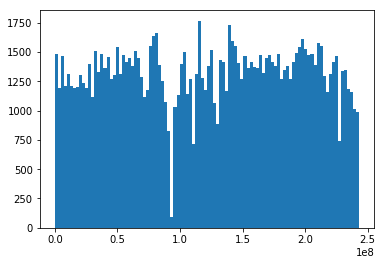

198206939
3
46
45


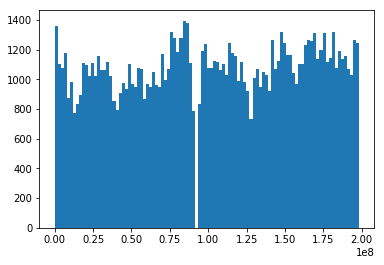

190123046
4
26
26


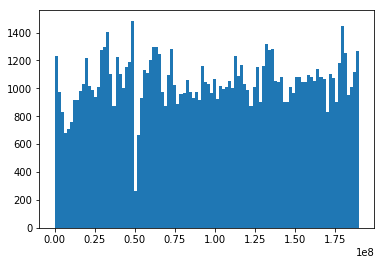

181477253
5
26
26


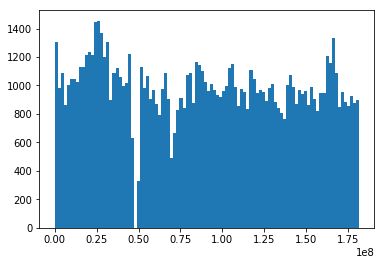

170740065
6
35
35


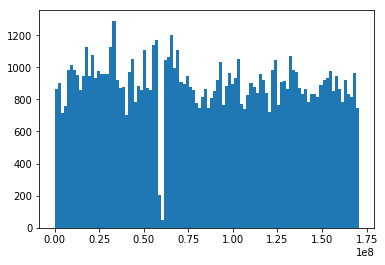

159332954
7
37
37


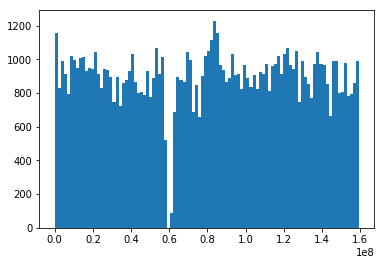

145075739
8
31
31


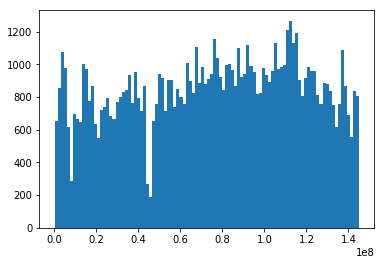

138237340
9
35
34


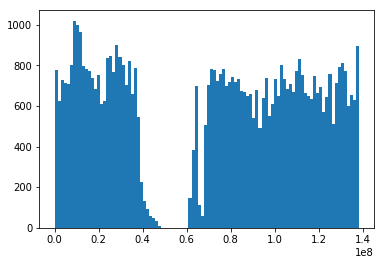

133787370
10
30
29


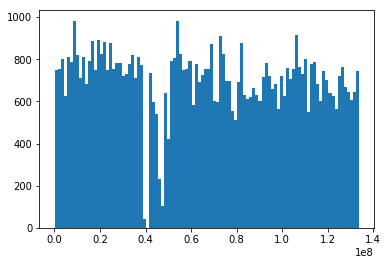

135076558
11
38
39


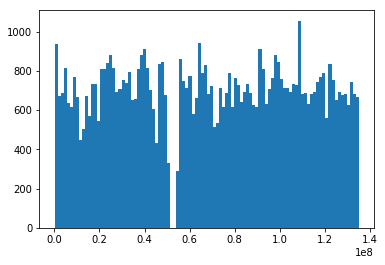

133263933
12
27
27


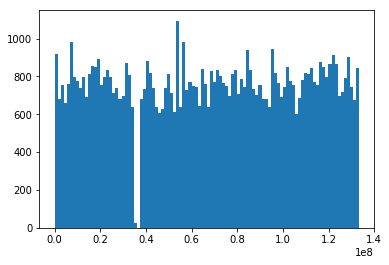

114344231
13
55
15


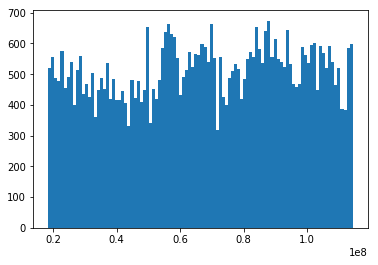

107192995
14
0
16


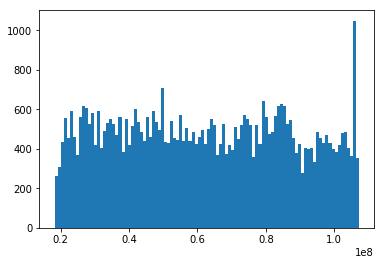

101981013
15
3
18


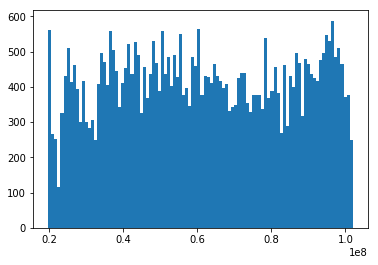

90228301
16
40
41


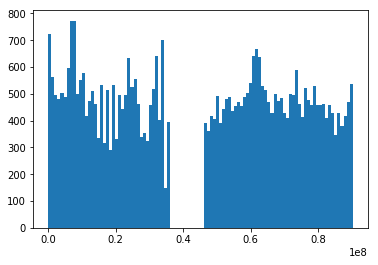

83246456
17
28
30


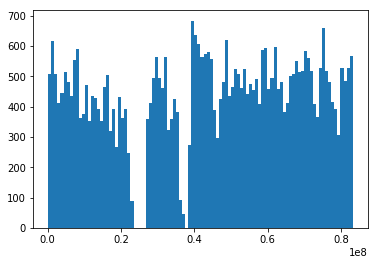

80258489
18
20
22


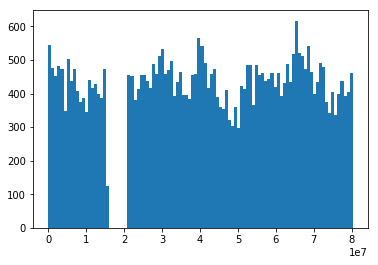

58607570
19
42
41


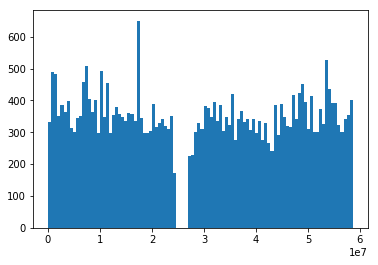

64333068
20
41
44


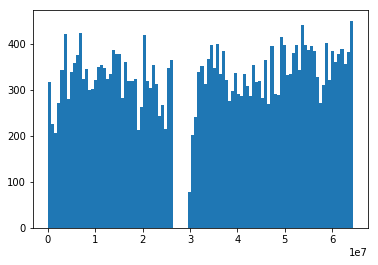

46699913
21
7
28


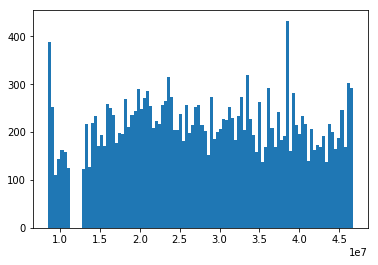

50804641
22
1
29


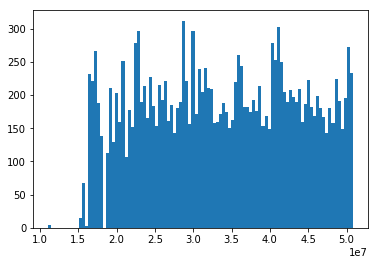

In [184]:
for i in range(1,23):
    s = just_indel_dict[i]['start']
    print(s.max())
    n,b,p = plt.hist(s,bins = 100)
    print(i)
    print(list(n).index(n.min()))
    print(centromere[i-1])
    
    plt.show()

## end of exploration of avoidance of centromeres

## repeats

In [318]:
i = 1
indel_type = 'deletions'


def get_repeats(just_indel_dict,deletions,i):
    ''''''
    index = set(just_indel_dict[i].index)&deletions

    indels = just_indel_dict[i].reindex(index)

    column = {'deletions':'WT_SEQ','insertions':'MUT_SEQ'}\
        [indel_type]

    indels['length'] = indels[column].map(lambda x:len(x))

    indels['start']-=1

    chromo = eval('Data.chromo{}'.format(i))()

    def is_repeat(row):
        s,c,le = row[['start',column,'length']]
        b,check,a = chromo[s-le:s],chromo[s:s+le],chromo[s+le:s+2*le]
        try:
            assert(c==check)
            return ( (b==c) or (c==a))
        except AssertionError:
            return np.nan



    return indels.apply(is_repeat,axis = 1)

In [329]:
def get_repeatsI(i):
    index = set(just_indel_dict[i].index)&insertions

    indels = just_indel_dict[i].reindex(index)

    column = 'MUT_SEQ'

    indels['length'] = indels[column].map(lambda x:len(x))

    indels['start']

    chromo = eval('Data.chromo{}'.format(i))()
    
    def is_repeat(row):
        s,c,le = row[['start',column,'length']]
        b,a = chromo[s-le:s],chromo[s:s+le]
        try:
            return ( (b==c) or (c==a))
        except AssertionError:
            return np.nan



    return indels.apply(is_repeat,axis = 1)

In [330]:
repeatsI = [get_repeatsI(i) for i in range(1,23)]

repeats = [get_repeats(i) for i in range(1,23)]

just_ins = just_indels.reindex(insertions) 

repeats1 = pd.concat(repeatsI).reindex(just_ins.index)

just_ins['repeat'] = repeats1

just_ins['indel']='insertion'

just_dels = just_indels.reindex(deletions) 

repeats0 = pd.concat(repeats).reindex(just_dels.index)

just_dels['repeat'] = repeats0

just_dels['indel'] = 'deletion'

just_ins['length'] = just_ins['MUT_SEQ'].map(len)
just_dels['length'] = just_dels['WT_SEQ'].map(len)

just_indels = pd.concat([just_ins,just_dels])

def grab (indel_type, length) :
    ji = just_indels.loc[(just_indels['indel']==indel_type)&(just_indels['length']==length)]['repeat']
    return ji.value_counts().reindex([True,False]).fillna(0).astype(int)

In [381]:
df_del = pd.DataFrame([grab('deletion',i) for i in range(1,21)])
df_del.index = range(1,21)

df_ins = pd.DataFrame([grab('insertion',i) for i in range(1,21)])
df_ins.index = range(1,21)

In [ ]:
df_del.to_csv('numbers_of_del_repeats_in_non-coding_region.csv')
df_ins.to_csv('numbers_of_ins_repeats_in_non-coding_region.csv')

## finished repeats

In [ ]:
def get_reps(row,indel_type,c_string):

    '''Identify how many repeats there are before and 
    after an indel and add them. Deletions and insertions
    are treated slightly differently. 
    The insertions are inserted between the start and stop position, whilst the 
    deletions delete the end points.'''
    
    w,m,start,stop = row[['WT_SEQ', 'MUT_SEQ', 'start' ,'stop']]

    if indel_type == 'deletions':
        after = c_string[stop:stop+100]
        before = c_string[start-101:start-1][::-1]
        mut = w
    else:
        after = c_string[stop-1:stop+99]
        before = c_string[start-100:start][::-1]
        mut = m

    length = len(mut)
    after_split = split_string(length,after)+['x']
    after_reps = next((i for i in range(len(after_split)) if after_split[i] != mut))
    before_split = split_string(length,before)+['x']
    mutr = mut[::-1]
    before_reps = next((i for i in range(len(before_split)) if before_split[i] != mutr))
    reps = before_reps+after_reps
    return {'reps':reps,'before_split':before_split,'after_split':after_split,'length':length}

In [ ]:
rep_groups = lambda df :df.groupby(by = 'reps').groups
length_groups = lambda df:df.groupby(by = 'length').groups

In [ ]:
def get_indel_repeats():
        '''putting the package together, given a chromosome and indel_type segregate the right
    part of just indels then identify the correct method needed for repeats
    and apply it, concatenate the answer with the existing dataframe and save it. Keep the key columns of the 
    dataframe and return them'''
    
    def repeats(chromo,indel_type,c_string):

        print('starting {} chromosome {}'.format(
            indel_type,chromo))
        df = get_indel_type(chromo,indel_type)
        get_indel = lambda row: get_reps(row,indel_type,c_string)
        reps = df.apply(get_indel,axis = 1)
        print('repeats retrieved')
        df = pd.concat([df, pd.DataFrame(list(reps),
                                index = reps.index)],axis=1)
        df.to_csv('{}_repeats_chromo{}.csv'.format(
            indel_type,chromo))
        print('dataframe saved')
        df['indel_type']=indel_type
        print('chromo {} {} complete'.format(chromo,indel_type))
        return df[['reps','length','indel_type','chromo']]
    
    dfs = []
    for chromo in range(1,24):
        c_string = getattr(Data,'chromo{}'.format(i))()
        #string of chromosome i
        for indel_type in ['insertions','deletions']:
            dfs.append(repeats(chromo,indel_type,c_string))

    rep_dfs = pd.concat(dfs)

    ins_dfs = rep_dfs.loc[rep_dfs['indel_type']=='insertions']
    del_dfs = rep_dfs.loc[rep_dfs['indel_type']=='deletions']
    
    ins_dfs.to_csv('ins_dfs.csv')
    del_dfs.to_csv('del_dfs.csv')
    return ins_dfs,del_dfs

In [ ]:
def get_heatmap(df):
    length_groups = df.groupby(by = 'length').groups
    return pd.DataFrame(dict([[i,df.reindex(length_groups[i])['reps'].value_counts()] 
                       for i in range(1,12)])).fillna(0).astype(int)

In [ ]:
def get_both_heatmaps():
    '''make and save ins_dfs and del_dfs and the logged 
    equivalents'''
    
    ins_dfs,del_dfs = get_indel_repeats()
    ins_heatmap = get_heatmap(ins_dfs)
    del_heatmap = get_heatmap(del_dfs)
    ins_heatmap.to_csv('ins_heatmap.csv')
    del_heatmap.to_csv('del_heatmap.csv')
    ins_heatmap.applymap(lambda x: max(x,0.5)).applymap(log).to_csv('log_ins_heatmap.csv')
    del_heatmap.applymap(lambda x: max(x,0.5)).applymap(log).to_csv('log_del_heatmap.csv')

In [ ]:
logs = {}
for i in ['ins','del']:
    df = eval('{}_heatmap'.format(i)).iloc[:15,:12]
    df0 = df.applymap(lambda x: x if x>0 else 0.5)
    logs[i] = df0.applymap(log)

# Analysis

Now we can see how the indels pan out in the non-coding region. 
For a start there are almost as many insertions as there are deletions. There tend to be slightly more
common deletion/repetitions and slightly more uncommon insertion/repetitions.

In [ ]:
def show_heatmap(df,ax,cmap):
    mx,mn = df.max().max(),df.min().min()
    #levels = MaxNLocator(nbins=15).tick_values(mn,mx)
    imshow = ax.imshow(df.values,cmap = plt.get_cmap(cmap)) 
    divider = make_axes_locatable(ax)
    ax.set_xticks(range(11))
    ax.set_xticklabels(range(1,12))
    cax = divider.append_axes("right", size="10%", pad=0.5)
    cbar = plt.colorbar(imshow, cax=cax, ticks=MultipleLocator(1))

fig,axarr = plt.subplots(2,2,figsize = (30,30))

for df,ax,cmap in [(logs['del'],axarr[0,0],'Blues'),
                   (logs['ins'],axarr[0,1],'Reds'),
                   ((logs['del']-logs['ins']).applymap(exp),
                    axarr[1,0],'Greens'),
                   ((logs['ins']-logs['del']).applymap(exp),
                    axarr[1,1],'Oranges')

                  ]:
    show_heatmap(df,ax,cmap)
plt.show()
    
